In [ ]:
import numpy as np
from Bio.PDB import PDBList
from pandas import DataFrame
import requests, json
import random
import os #, os.path
from biopandas.pdb import PandasPdb
import sys
from six.moves import urllib
from numba import jit,float32
from pathlib import Path
import nglview as nv
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import urllib
import csv as cs
import shutil as sht
import glob as gbl

# Protein classification using Gauss integral and Dscan 
- Lucia Depaoli
- Alessandro Fella
- Simone Mistrali
- Lorenzo Mandolito
   
   


## Introduction


Classify structure of proteins is an important task in biology. In particoular the secondary structure of a protein is determined by the geometric distribution of the amino acid residues. There are $2$ main secondary structures:





# <center>Alpha Helix</center>
![](files/alpha_trasparent.png)

# <center>Alpha Helix</center>
![](files/beta_sheet.png)

The chain of the carbon atoms $\{C_{\alpha}\}_{\alpha = 1 \dots N}$ (where $N$ is the length of the protein), is the backbone of the geometrical structure of the protein.

In this work we classify the structure of $20000$ protein. We get the coordinations of the $C_{\alpha}$ from the [Protein Data Bank (PDB)](https://www.rcsb.org/).
The main idea is to map the protein's geometry into a topological curve, this allows us to compute the Writhe $W_r$ over the polygonal obtained from the $C_{\alpha}$ coordinates: 

$$
I(i_1,i_2) = \sum_{0 < i_1 < i_2 < N} W_r(i_1,i_2)
$$

**SPIEGARE WRITHE**

The computation of the Writhe yelds $14$ features that determine clusters of proteins,  

We follow the classification convention of the [CATH](https://www.cathdb.info/) database, in which there are $6$ structures:


**INSERIRE GRAFICI**


In [1]:
#Download protein's ID
df = pd.read_csv("./CATH/cath-domain-list.txt",skiprows=16,names=["CATH_ID","Class_Number","Architecture_number","Topology_number","Homologous_superfamily_number",
                                                    "S35","S60","S95","S100_number","S100_count","Domain_length","resolution"],delim_whitespace=True)
df_new = df[df.resolution!=1000]
df_new["CATH_ID"] = df_new["CATH_ID"].map(lambda x: str(x)[:-3])
df_new = df_new.drop_duplicates("CATH_ID")
cath_id = np.array(df_new["CATH_ID"])
df_new = df_new.set_index(np.arange(0,len(cath_id)))

print(len(df_new))
df_new=df_new.sort_values(by=['CATH_ID'],ignore_index=True)

NameError: name 'pd' is not defined

In [ ]:
# Download PDB file
# PDBcode is the name of the protein

def download_pdb(pdbcode, datadir, downloadurl="https://files.rcsb.org/download/"):    
    #os.mkdir('PDB')
    pdbfn = pdbcode + ".pdb"
    url = downloadurl + pdbfn
    outfnm = os.path.join(datadir, pdbfn)
    try:
        urllib.request.urlretrieve(url, outfnm)
        return outfnm
    except:
        return None

In [ ]:
# Extract the x,y,z coordinates of the CA atoms for a given protein

def get_coord(x):

    try:
        ppdb = PandasPdb().fetch_pdb(x.lower())
        mainchain = ppdb.df['ATOM'][(ppdb.df['ATOM']['atom_name'] == 'CA')]

        a = mainchain[['x_coord', 'y_coord', 'z_coord']]

        N = len(a)
        coord = np.zeros((N,3))
        coord = np.array(a)

        return coord
    except AttributeError:
        return int(0)

In [ ]:
# Reject a protein if the number of missing CA atoms is >3

def missing_atoms (inFile,h=3):

    """
    Input inFile-> PDB File, h-> How much missing CA you allowed?
    """
    c = 0
    FLAG = False
    # If j=TRUE the protein is ok
    j = True
    missing_atoms = [] 
    k = False
    for line in inFile:
        if FLAG==True and line.split()[1]=='470':
            k = True
            line[28:].replace('  ','   ')
            atoms = line[28:].split('   ')
            c += np.sum(np.char.count(atoms,"CA"))
        if ['REMARK','470'] != line.split(' ')[0:2]:
            FLAG = False
        if 'REMARK 470   M RES CSSEQI  ATOMS' == line.strip():
            FLAG = True
            atoms = []
        if c>h:
            j = False
            break
        
    return j

In [ ]:
# Get coord of a protein and save it in a txt file inside /prot_coord

def get_data(N):

    unique_numbers = np.sort(random.sample(range(0, len(df_new["CATH_ID"])),N+int(0.2*N)))
    c = 0
    cath_domain = []
    prot_name = []
    pdbl = PDBList()
    if not os.path.exists("./prot_coord/"):
        os.makedirs("./prot_coord/")
    np.sort(df_new["CATH_ID"])
    for i in unique_numbers:
        prot_name.append((df_new["CATH_ID"][i]).lower())
        j = df_new["CATH_ID"][i]

        download_pdb(j, 'PDB')
        flag = missing_atoms("PDB/" + j + ".pdb")
 
        if os.path.exists('./PDB/' + j + '.pdb') == True:
            os.remove("PDB/" + j + ".pdb")  
            
        if flag == True:
            coord = get_coord(j)
            if type(coord)!= int:
                np.savetxt("./prot_coord/" + j + '.txt', coord)
                c += 1
                a=f"{df_new['Class_Number'][i]}.{df_new['Architecture_number'][i]}.{df_new['Topology_number'][i]}.{df_new['Homologous_superfamily_number'][i]}"
                cath_domain.append(a)
        if (c == N):
            break
        
    #print(c)

    return cath_domain

In [ ]:
@jit(nopython=True)
def tripleprod(a,b,c):
    return a[0]*(b[1]*c[2]-b[2]*c[1])+a[1]*(b[2]*c[0]-b[0]*c[2])+a[2]*(b[0]*c[1]-b[1]*c[0])

@jit(nopython=True)
def dist(a):
    return np.sqrt(a[1]**2 + a[0]**2 + a[2]**2)

@jit(nopython=True)
def writhe_matrix(M):

    N    = M.shape[0]
    W    = np.zeros((N-1,N-1))

    for i in range(N-1):
        dri  = M[i+1,:] - M[i,:]
        drih = 0.5*(M[i+1,:] + M[i,:])
        
        for j in range(i+1,N-1):
            drj = M[j+1,:] - M[j,:]
            drij = 0.5*(M[j+1,:] + M[j,:]) - drih
            
            v = tripleprod(dri,drij,drj)
            if(v!=0):
                k = dist(drij)
                k = k**3
                W[i,j] = v/k
    return W

@jit(nopython=True)#,parallel=True)
def create_I2(prot_coord):
    W = writhe_matrix(prot_coord)

    v = np.zeros(15)
    N = len(W)
    # Length of the protein
    v[0] = N+1

    for i in range(N-1):
        for j in range(i+2,N-1):
            # # I_()()
            v[1] += W[i,j]
            v[2] += abs(W[i,j])
            v[3] += W[i,i+1]*W[j,j+1]
            v[4] += abs(W[i,i+1])*W[j,j+1]
            v[5] += W[i,i+1]*abs(W[j,j+1])
            v[6] += abs(W[i,i+1]*W[j,j+1])
    for i in range(N-2):
        for j in range(i+3,N-2):

            v[7] += W[i,i+2]*W[j,j+2]
            v[8] += abs(W[i,i+2])*W[j,j+2]
            v[9] += W[i,i+2]*abs(W[j,j+2])
            v[10] += abs(W[i,i+2]*W[j,j+2])
    for i in range(N-3):
        for j in range(i+1,N-1):
            v[11] += W[i,i+3]*W[j,j+1]
            v[12] += abs(W[i,i+3])*W[j,j+1]
            v[13] += W[i,i+3]*abs(W[j,j+1]) 
            v[14] += abs(W[i,i+3]*W[j,j+1])
    v[1:2] /=v[0]   
    v[3:N-1] /= v[0]**2
    return v

In [ ]:
cath_domain = np.array(get_data(20000))

URL Error [Errno 110] Connection timed out
URL Error [Errno 110] Connection timed out


In [ ]:
f = open("./labels.txt","a")
csvwriter = cs.writer(f,delimiter="\n") 
csvwriter.writerow(cath_domain)
f.close()

In [ ]:
directory = "./prot_coord/"
dirout = "./coord_done/"
files = sorted(glb.glob(directory + '*'))
print(files)
N_prot = len([name for name in os.listdir(directory)])

cath_file = open("./labels.txt","r")
cath_lines = cath_file.readlines()
cath_domain = []
for i in range(len(cath_domain)):
    cath_domain.append(cath_domain[i][:-1])

k=0
 
for i in files:
    if True:
        f = open("./coord_prot.txt","a")
        csvwriter = cs.writer(f) 
        prot_coord = np.genfromtxt(i,delimiter=' ')
        v = create_I2(prot_coord)
        xx = np.append(v,i[-8:-4])
        vector = np.append(xx, cath_domain[k])
        if os.path.exists('prot_coord/' + i[-8:-4]+ '.txt') == True:
            sht.move("prot_coord/"+i[-8:-4]+ ".txt",dirout)
        #    os.remove('prot_coord/' + i.stem+ '.txt')
        csvwriter.writerow(vector)
        f.close()
        k +=1

['./prot_coord/1pye.txt', './prot_coord/3qrh.txt', './prot_coord/4iwf.txt', './prot_coord/4yu4.txt', './prot_coord/5e2t.txt']


# Clustering and import dataframe

In [ ]:
data_to_append = {}
df_ = pd.DataFrame(columns=['Prot_ID', 'CATH_ID', 'col1', 'col1', 'col3', 'col4', 'col5', 'col6', 
'col7','col8', 'col9', 'col10', 'col11','col12', 'col13', 'col14', "col15"])

for j in range(len(features)):
    data_to_append[j] = {}
    for i in range(len(df_.columns)):
        data_to_append[j][df_.columns[i]] =features[j,i]
data = pd.DataFrame(data_to_append).T

,Prot_ID,CATH_ID,col1,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15
0,4e6c,2.60.40.420,0.31170890231633136,970.7036821630425,-7.802683381049346e-34,5.0754300152735466e-33,-1.378227637779911e-32,1.5390848207101003e-31,0.021203032430485637,0.03511800918967349,0.02876025303003601,0.047784268776470205,1.074426449012204e-18,1.5247979468656148e-18,3.8087129785954536e-17,5.3110140700097075e-17
1,4h3l,2.70.240.10,-0.06987128082719947,1529.6634498086748,-6.874060150264086e-34,-5.8611777833470474e-33,1.3490763179712627e-34,9.068034999444876e-32,0.00016935504491880025,0.0008859960602518361,0.0018191611946229444,0.007909638564233741,-2.707361811804631e-19,-1.0004994733274613e-18,4.185607173896433e-18,1.784480083208429e-17
2,3ac3,1.20.90.10,0.2831581092554254,756.9497344371681,-5.295807917016563e-34,2.6854372109298996e-33,4.2314796070933994e-33,8.4197197948259e-32,0.021153818308886355,0.03438771814382156,0.030407921202131098,0.049219861242423474,1.0152979687436846e-18,1.4668722238069115e-18,3.180388595812096e-17,4.7584464420389095e-17
3,3m2l,1.10.510.10,0.03752371617874254,11456.246278022569,-8.071583153642754e-34,-3.269629502155907e-32,2.353403730124066e-32,6.269843144896139e-31,8.976826932125887e-05,0.0008079379941605582,0.0008919929896230547,0.007327883865143657,-5.575374239757695e-19,-1.9786619824824644e-18,1.1265618082244871e-17,4.0192738222922006e-17
4,1zm6,3.40.190.170,0.44265170175243895,282.7885389978563,4.5421679509897295e-33,-8.776845750012064e-32,-6.711740790818252e-32,5.595656849086856e-31,0.029011949122978248,0.03799443846086699,0.03958502225916297,0.05138192685087395,-1.8309250637265522e-17,-2.2623777816881e-17,1.1884488640995558e-16,1.4499899630153386e-16
5,5yz2,1.10.1280.10,0.2862812207134009,700.564432243557,1.4766830410893608e-33,-2.3897725508260352e-32,-1.0740875161831352e-32,1.279364981819615e-31,0.01819829064224846,0.03005014829940321,0.027915451017340297,0.045729049357347666,-7.44967431611535e-18,-1.0051962948960188e-17,3.835864415480682e-17,5.205618941232092e-17
6,4yvn,3.90.1280.20,-0.05032268998153673,1775.6608475258383,5.222911480476184e-34,2.4947015390396386e-32,1.4536229029558203e-32,2.5377809670419936e-31,-5.170978818689113e-05,0.000829154154991652,0.00021045350468780653,0.011689276553014584,7.147093099472656e-19,3.0946161375194214e-18,5.9887954381762166e-18,3.422388545943732e-17
7,4oly,2.60.40.10,0.02287596866986343,2850.061013764802,-3.7208772595654093e-34,3.293649045617011e-33,9.302295965603191e-33,1.865349885191297e-31,0.0008130413698058238,0.0021652954588814825,0.004607656904906246,0.013089717780132308,6.024819551725577e-19,1.0045148091802082e-18,2.065796467750156e-17,3.853673601490669e-17
8,5i3b,2.40.155.10,0.4953225453439254,2209.333140175661,-4.0265299153152926e-33,1.3567509144818886e-32,4.1409051498619983e-32,1.7428289399951667e-30,0.02910840194126128,0.0401661144893178,0.041047208849554796,0.056523133620109065,1.4648034894237215e-18,1.9403048739874575e-18,1.7667528277997865e-16,2.4274827881128203e-16
9,4mni,1.10.510.10,0.5123926935836013,935.162875732013,5.060808064182276e-33,-6.026706437854155e-32,-5.371104541159205e-32,4.321098361918788e-31,0.029703459675011173,0.041231171679006653,0.037088246384934236,0.05147173064987358,-9.331182319004407e-18,-1.2401944130514632e-17,7.861644411569416e-17,9.820481216523522e-17


### Check if create_I2 is meaningful


In [ ]:
#with a straight line

n = 10000
t_max = 16 * np.pi
t = np.linspace(0, t_max, n)

line = np.zeros((n,3))
line[:,0]=t
line[:,1]=t
line[:,2]=t

v_1=create_I2(line)
v_1

array([10000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.])

In [ ]:
#with a helix

num = [100,150, 200, 300, 500, 750, 1000, 1700, 2000, 3000, 5000, 7000, 10000]
v = []
for i in num:
    t = np.linspace(0, t_max, i)

    x = np.cos(t)
    y = np.sin(t)
    z = t

    helix = np.zeros((i,3))
    helix[:,0]=x[:]
    helix[:,1]=y[:]
    helix[:,2]=z[:]
    helix
    v1=create_I2(helix)
    v.append(v1[2])

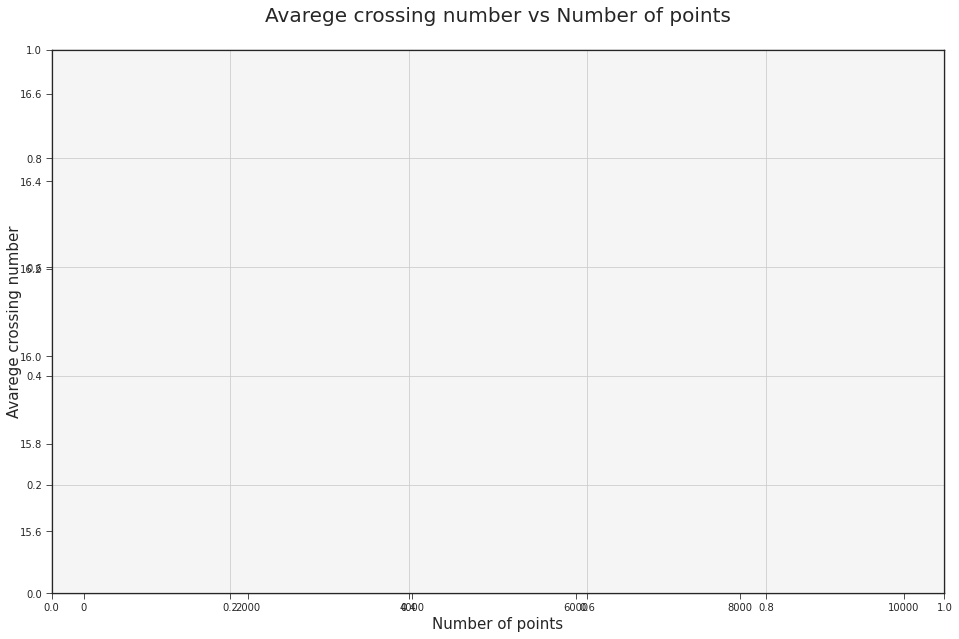

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(num, v,"--b")
plt.scatter(num,v,marker = "o", s =50, c = "r")
plt.title("Avarege crossing number vs Number of points\n",fontsize=20)
plt.style.use('seaborn-ticks')
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.xlabel("Number of points",fontsize=15)
plt.ylabel("Avarege crossing number",fontsize=15)
plt.grid()
plt.show()

In [ ]:
0.5*20000

10000.0

In [ ]:
x=np.loadtxt("prot_coord/2www.txt", delimiter=" ")
x_p=x[:,0] 
y_p=x[:,1]
z_p=x[:,2]

fig = go.Figure(data=go.Scatter3d(
    x=x_p, y=y_p, z=z_p,
    marker=dict(
        size=3,
        color=z_p,
        colorscale='icefire',
    ),
    line=dict(
        color='darkblue',
        width=3
    )
))

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show() 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=deb3820e-5638-4932-87bf-a276194132a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>